In [15]:
import numpy as np
import psana as ps
import matplotlib.pyplot as plt
import sys
import time
import pickle
from Functions import *
from raw_data_class import RawData as RDC
#from processed_data_class import ProData as PDC
%matplotlib notebook

In [35]:
save_dir = '/cds/home/b/bpoult/LCLS_LV_27_Data_Analysis/sample_data/'
calib_dir = '/cds/home/b/boult/LCLS_LV_27_Data_Analysis/calibrations/'
calibration_file = ''
epix_pos = 1 # This position corresponds to: 
runs = list(range(207,214)) # goes from first value in range to last - 1
epix_roi = [80,140,170,330]
xrt_roi = [725,1500]


# Processing or Loading
process_raw = False
on_off = True # Do you want to plot the raw data?
plot_one = 207
x_axis = 'pixels' # 'pixels' or 'energy'

exp=cxix46119:run=207:smd
exp=cxix46119:run=208:smd
exp=cxix46119:run=209:smd
exp=cxix46119:run=210:smd
exp=cxix46119:run=211:smd
exp=cxix46119:run=212:smd
exp=cxix46119:run=213:smd


<IPython.core.display.Javascript object>


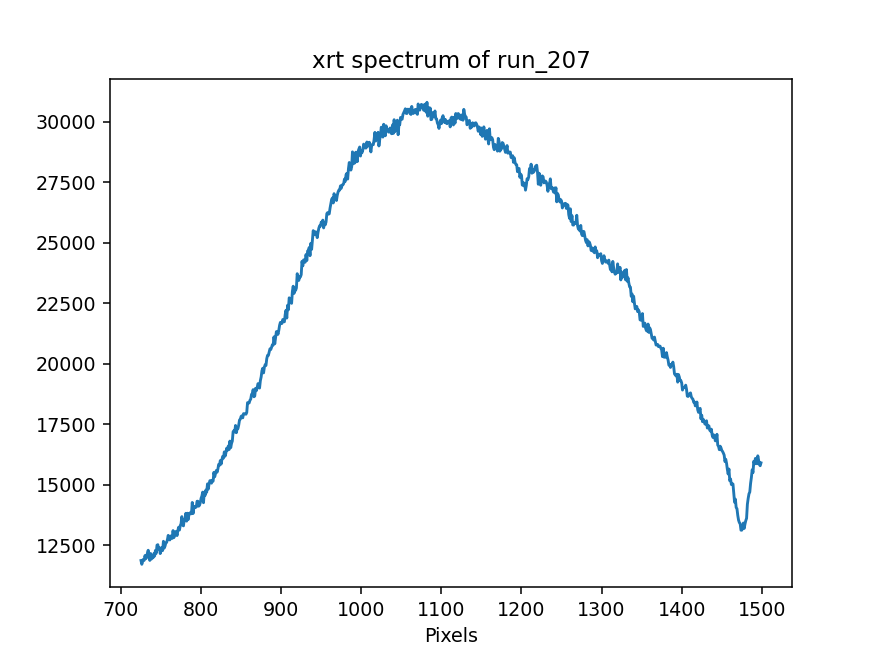

<IPython.core.display.Javascript object>


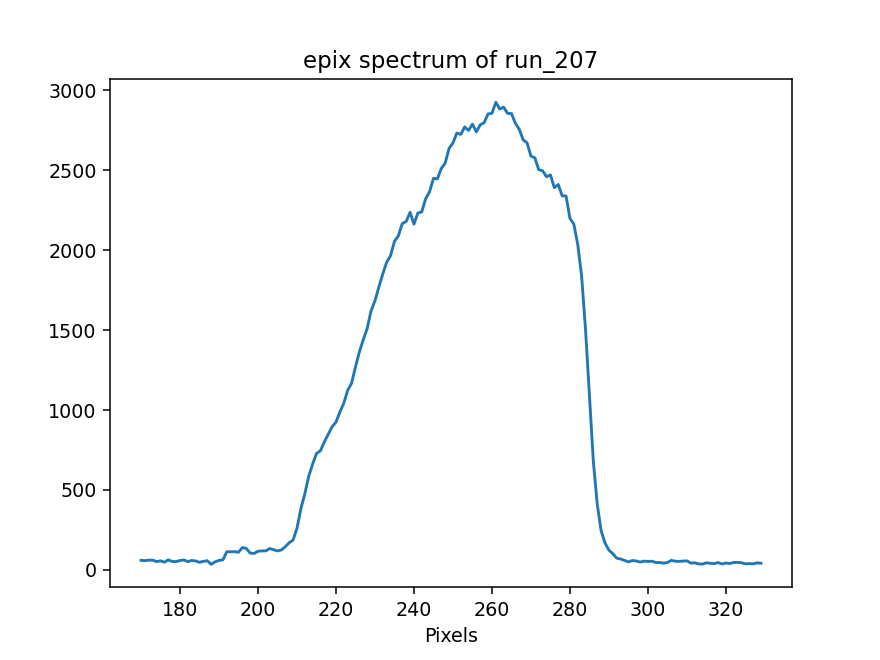

<IPython.core.display.Javascript object>


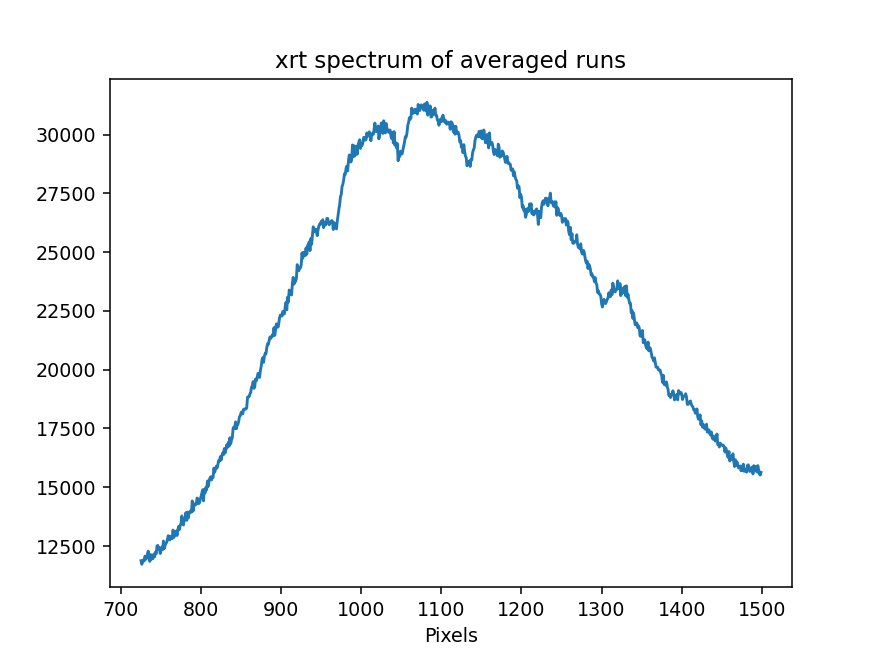

<IPython.core.display.Javascript object>


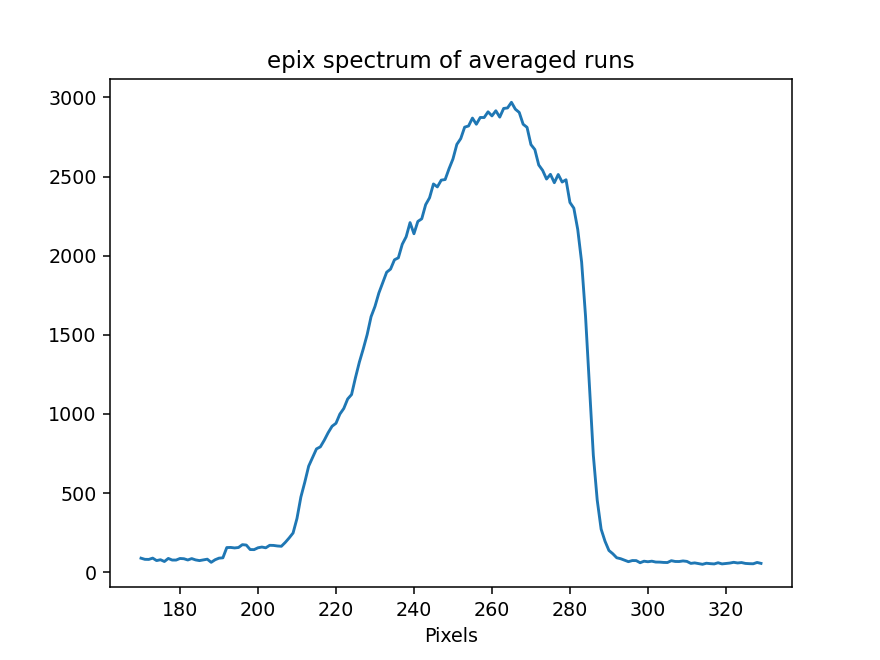

<IPython.core.display.Javascript object>


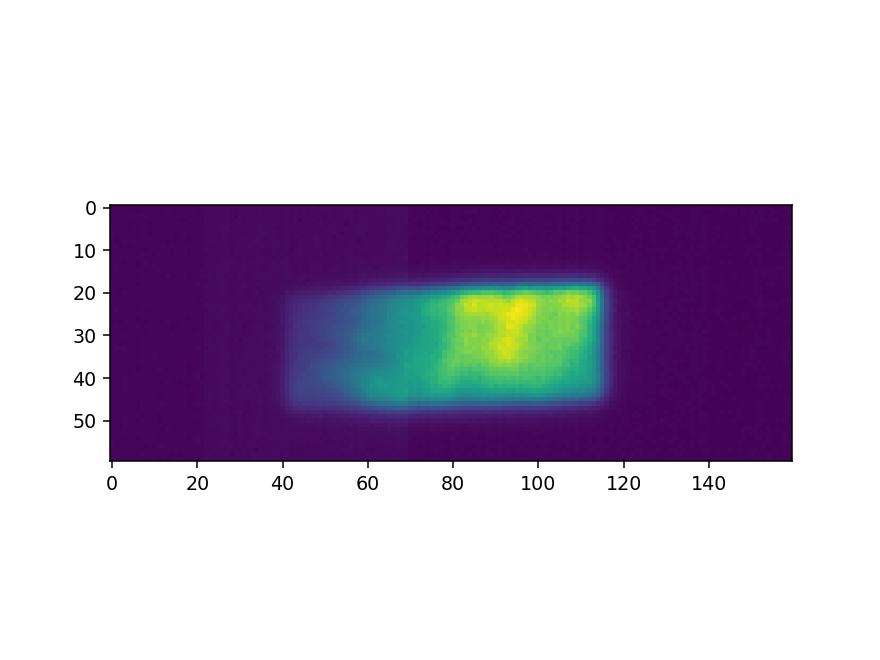

In [36]:
# Raw Data
raw_datas = []
for run in runs:
    scan_name = 'run_' + f'{run:03}'
    ds_string = 'exp=cxix46119:run='+str(run)+':smd'
    print(ds_string)
    if process_raw:
        raw_data = load_data.load_data(save_dir,scan_name,ds_string,epix_roi,xrt_roi)
    else:
        with open(save_dir + scan_name + "/" + "rawdata.pkl", "rb") as f:
            raw_data = pickle.load(f)
            
    raw_datas = raw_datas + [raw_data]

plot_raw.plot_raw(raw_datas, plot_one, x_axis, on_off)

plt.figure()
plt.imshow(raw_data.avg_epix_2d)
plt.show()

In [31]:
# Energy Calibration, plot raw calibration runs with pixel axis and populate these arrays
save_cal = False
labels = ['notch_energies','xrt_pixels','epix_pixels','calib_runs','epix_pos']
notch_energies = [7.06,7.065,7.07,7.075,7.08,7.085,7.09] # keV
xrt_pixels = [1474,1385,1297,1216,1131,1048,966] # enter 0 if you can't see the notch
epix_pixels = [0,223,236,248,262,274,0] # enter 0 if you can't see the notch
calib_runs = list(range(207,214))
calib_data = [labels, notch_energies,xrt_pixels,epix_pixels]
raw_datas = [energy_calib.energy_calib(raw_datas[i],calib_data,save_cal) for i in range(0,len(raw_datas))]

[['notch_energies',
  'xrt_pixels',
  'epix_pixels',
  'xrt_energy',
  'epix_energy',
  'time_calibrated'],
 [7.06, 7.065, 7.07, 7.075, 7.08, 7.085, 7.09],
 [1474, 1385, 1297, 1216, 1131, 1048, 966],
 [0, 223, 236, 248, 262, 274, 0],
 array([7.10411397, 7.10405476, 7.10399555, 7.10393634, 7.10387713,
        7.10381792, 7.10375871, 7.1036995 , 7.10364029, 7.10358109,
        7.10352188, 7.10346267, 7.10340346, 7.10334425, 7.10328504,
        7.10322583, 7.10316662, 7.10310741, 7.1030482 , 7.10298899,
        7.10292978, 7.10287058, 7.10281137, 7.10275216, 7.10269295,
        7.10263374, 7.10257453, 7.10251532, 7.10245611, 7.1023969 ,
        7.10233769, 7.10227848, 7.10221928, 7.10216007, 7.10210086,
        7.10204165, 7.10198244, 7.10192323, 7.10186402, 7.10180481,
        7.1017456 , 7.10168639, 7.10162718, 7.10156798, 7.10150877,
        7.10144956, 7.10139035, 7.10133114, 7.10127193, 7.10121272,
        7.10115351, 7.1010943 , 7.10103509, 7.10097588, 7.10091668,
        7.10085747

In [10]:
# Filtering Raw Data: filter[0] = 'filter_name'
                    # filter[1] = True/False to turn on/off that filter
                    # filter[2:end] = 1 value per index
filter1 = ['xx',True,1,1,1,1]
filter2 = ['yy',True,2,2,2]
filter3 = ['zz',False,3]


filter_parameters = [filter1, filter2, filter3]
which_filters = [filter_parameters[i][1] for i in range(0,len(filter_parameters))]
filters_to_use = [filter_parameters[i] for i in range(0,len(filter_parameters)) if which_filters[i]==True]
filters_to_use

[['xx', True, 1, 1, 1, 1], ['yy', True, 2, 2, 2]]

In [ ]:
# Overlapping Data: matches energy ranges, resolutions, spectrometer response, and normalizes to upstream